# 📌 BiLSTM for Multi-step Sales Forecasting

In [2]:
# ===============================
# 📌 Import library
# ===============================
# General
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

# SciKeras wrapper
from scikeras.wrappers import KerasRegressor

# TensorFlow / Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [3]:
# ===============================
# 📌 Load dataset
# ===============================
df = pd.read_csv("Final dataset.csv")
df['Invoice Date'] = pd.to_datetime(df['Invoice Date'])
df.sort_values('Invoice Date', inplace=True)

# Aggregate daily sales
daily_sales = df.groupby('Invoice Date')['Sales Amount'].sum().reset_index()
daily_sales.set_index('Invoice Date', inplace=True)

# ===============================
# 📌 Apply 7-day Moving Average smoothing
# ===============================
daily_sales['Sales_MA7'] = daily_sales['Sales Amount'].rolling(window=7, min_periods=1).mean()
sales_series = daily_sales[['Sales_MA7']]

# ===============================
# 📌 Sequence creation for multi-output (7 days ahead)
# ===============================
def create_multi_output_sequences(data, window_size, output_size):
    x, y = [], []
    for i in range(len(data) - window_size - output_size + 1):
        x.append(data[i:i+window_size])
        y.append(data[i+window_size:i+window_size+output_size])
    return np.array(x), np.array(y)

WINDOW_SIZE = 30
OUTPUT_DAYS = 7

# Create sequences
X_all, y_all = create_multi_output_sequences(sales_series.values, WINDOW_SIZE, OUTPUT_DAYS)

In [4]:
# ===============================
# 📌 Train / Val / Test Split
# ===============================
split1 = int(0.8 * len(X_all))      # 80% train+val, 20% test
split2 = int(0.9 * split1)          # from train+val, 10% for validation

X_train_raw, y_train_raw = X_all[:split2], y_all[:split2]
X_val_raw, y_val_raw     = X_all[split2:split1], y_all[split2:split1]
X_test_raw, y_test_raw   = X_all[split1:], y_all[split1:]   # reserved for final evaluation

In [5]:
# ===============================
# 📌 Apply MinMaxScaler (fit only on Train)
# ===============================
scaler = MinMaxScaler()
scaler.fit(X_train_raw.reshape(-1, 1))  # ✅ only fit on training data

X_train = scaler.transform(X_train_raw.reshape(-1, 1)).reshape(X_train_raw.shape)
X_val   = scaler.transform(X_val_raw.reshape(-1, 1)).reshape(X_val_raw.shape)
X_test  = scaler.transform(X_test_raw.reshape(-1, 1)).reshape(X_test_raw.shape)

y_train = scaler.transform(y_train_raw.reshape(-1, 1)).reshape(y_train_raw.shape)
y_val   = scaler.transform(y_val_raw.reshape(-1, 1)).reshape(y_val_raw.shape)
y_test  = scaler.transform(y_test_raw.reshape(-1, 1)).reshape(y_test_raw.shape)

# Reshape for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val   = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [6]:
# ===============================
# 📌 BiLSTM Model Builder
# ===============================
def build_bilstm_multi_output(input_shape, output_size):
    model = Sequential()
    model.add(Input(shape=input_shape))  
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.3))
    model.add(Dense(output_size))
    model.compile(optimizer='adam', loss='huber')
    return model

model = build_bilstm_multi_output((X_train.shape[1], 1), OUTPUT_DAYS)

# ===============================
# 📌 Callbacks
# ===============================
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

In [7]:
# ===============================
# 📌 Train
# ===============================
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

# ===============================
# 📌 Evaluation Function
# ===============================
def evaluate_and_report(X, y, name):
    y_pred = model.predict(X, verbose=0)
    y_inv = scaler.inverse_transform(y.reshape(-1, 1)).reshape(y.shape)
    y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)

    r2 = r2_score(y_inv.flatten(), y_pred_inv.flatten())
    rmse = sqrt(mean_squared_error(y_inv.flatten(), y_pred_inv.flatten()))
    mae = mean_absolute_error(y_inv.flatten(), y_pred_inv.flatten())

    print(f"[{name}] R²: {r2:.4f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")
    return r2, rmse, mae, y_inv, y_pred_inv

# Evaluate Train / Val / Test
print("\n=== Evaluation Results ===")
r2_train, rmse_train, mae_train, y_train_inv, y_train_pred_inv = evaluate_and_report(X_train, y_train, "Train")
r2_val, rmse_val, mae_val, y_val_inv, y_val_pred_inv           = evaluate_and_report(X_val, y_val, "Validation")



Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0727 - val_loss: 0.0343 - learning_rate: 0.0010
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0275 - val_loss: 0.0253 - learning_rate: 0.0010
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0246 - val_loss: 0.0268 - learning_rate: 0.0010
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0224 - val_loss: 0.0235 - learning_rate: 0.0010
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0232 - val_loss: 0.0233 - learning_rate: 0.0010
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0207 - val_loss: 0.0225 - learning_rate: 0.0010
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0216 - val_loss: 0.0227 - learning_rate: 0.0010
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0202 - val_loss: 0.0207 - learning_rate: 0.0010
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0194 - val_loss: 0.0194 - learning_rate: 0.0010
Epoch 10/50
12/12 ━

In [8]:
# ===============================
# 📌 Results Table (with % error)
# ===============================
metrics_df = pd.DataFrame([
    {"Dataset": "Train", "R²": r2_train, "RMSE": rmse_train, "MAE": mae_train,
     "MAPE (%)": np.mean(np.abs((y_train_inv.flatten()-y_train_pred_inv.flatten())/y_train_inv.flatten()))*100},
    {"Dataset": "Validation", "R²": r2_val, "RMSE": rmse_val, "MAE": mae_val,
     "MAPE (%)": np.mean(np.abs((y_val_inv.flatten()-y_val_pred_inv.flatten())/y_val_inv.flatten()))*100},

])
print("\nPerformance Summary:")
print(metrics_df.to_string(index=False))


Performance Summary:
   Dataset       R²         RMSE          MAE  MAPE (%)
     Train 0.577939 62673.867811 50128.837297 16.822683
Validation 0.521457 73373.822839 58725.657486 20.493688


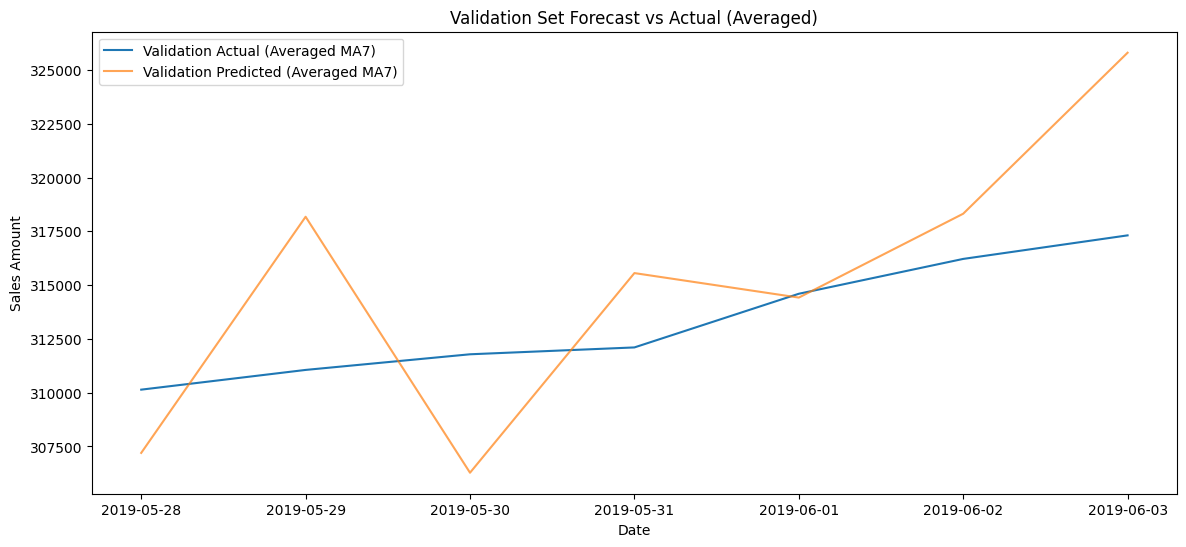

In [9]:
# ==============================
# 📌 Validation time series comparison (Averaged)
# ===============================

# Reshape predictions and true values back to (num_samples, OUTPUT_DAYS)
# Each row = one validation sample, each column = one step in the forecast horizon
y_val_pred_seq = y_val_pred_inv.reshape(-1, OUTPUT_DAYS)
y_val_true_seq = y_val_inv.reshape(-1, OUTPUT_DAYS)

# ✅ Align overlapping forecasts by averaging across all validation samples
# This ensures that each day in the forecast horizon has only one averaged value
avg_val_pred = y_val_pred_seq.mean(axis=0)
avg_val_true = y_val_true_seq.mean(axis=0)

# Build date index (length = OUTPUT_DAYS) for the averaged forecast horizon
val_index_avg = pd.date_range(
    start=daily_sales.index[split2+WINDOW_SIZE],  # validation start date
    periods=OUTPUT_DAYS,                         # only OUTPUT_DAYS days (averaged horizon)
    freq="D"
)

# Plot averaged actual vs predicted values
plt.figure(figsize=(14,6))
plt.plot(val_index_avg, avg_val_true, label="Validation Actual (Averaged MA7)")
plt.plot(val_index_avg, avg_val_pred, label="Validation Predicted (Averaged MA7)", alpha=0.7)
plt.title("Validation Set Forecast vs Actual (Averaged)")
plt.xlabel("Date")
plt.ylabel("Sales Amount")
plt.legend()
plt.show()



Next 7 Days Forecast:
        Date  Predicted Sales Amount (MA7)
0 2020-01-01                  290160.81250
1 2020-01-02                  334980.21875
2 2020-01-03                  339814.40625
3 2020-01-04                  362742.90625
4 2020-01-05                  363229.00000
5 2020-01-06                  368983.75000
6 2020-01-07                  366830.31250


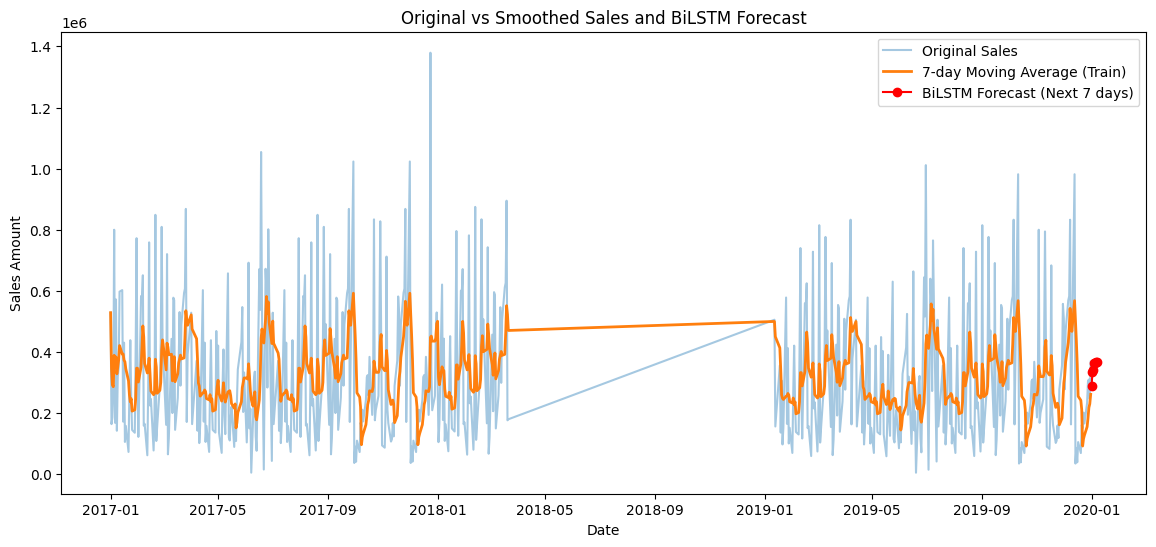

In [10]:
# ===============================
# 📌 Forecast next 7 days
# ===============================
last_input = scaler.transform(sales_series.values[-WINDOW_SIZE:].reshape(-1, 1)).reshape(1, WINDOW_SIZE, 1)
future_pred_scaled = model.predict(last_input, verbose=0)[0]
future_pred = scaler.inverse_transform(future_pred_scaled.reshape(-1, 1))

future_dates = pd.date_range(start=daily_sales.index[-1] + pd.Timedelta(days=1), periods=7)
forecast_df = pd.DataFrame({'Date': future_dates, 'Predicted Sales Amount (MA7)': future_pred.flatten()})
print("\nNext 7 Days Forecast:")
print(forecast_df)

plt.figure(figsize=(14,6))
plt.plot(daily_sales.index, daily_sales['Sales Amount'], label="Original Sales", alpha=0.4)
plt.plot(daily_sales.index, daily_sales['Sales_MA7'], label="7-day Moving Average (Train)", linewidth=2)
plt.plot(forecast_df['Date'], forecast_df['Predicted Sales Amount (MA7)'],
         marker='o', label="BiLSTM Forecast (Next 7 days)", color="red")
plt.title("Original vs Smoothed Sales and BiLSTM Forecast")
plt.xlabel("Date")
plt.ylabel("Sales Amount")
plt.legend()
plt.show()

# 📌 BiLSTM Hyperparameter Tuning with RandomizedSearchCV

In [11]:
# ------------------------
# Build BiLSTM model
# ------------------------
def build_bilstm_model(units1=128, units2=64, dropout=0.3, learning_rate=0.001):
    """
    Build a BiLSTM model for multi-step forecasting.
    """
    model = Sequential()
    model.add(Input(shape=(WINDOW_SIZE, 1)))   # avoid UserWarning
    model.add(Bidirectional(LSTM(units1, return_sequences=True)))
    model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(units2)))
    model.add(Dropout(dropout))
    model.add(Dense(OUTPUT_DAYS))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss="huber")
    return model

# Wrap Keras model
regressor = KerasRegressor(model=build_bilstm_model, verbose=0)

# ------------------------
# Define parameter search space
# ------------------------
param_dist = {
    "model__units1": [64, 128, 256],
    "model__units2": [32, 64, 128],
    "model__dropout": [0.2, 0.3, 0.5],
    "model__learning_rate": [1e-2, 1e-3, 5e-4],
    "batch_size": [16, 32],
    "epochs": [20, 50]
}


In [12]:
# ------------------------
# Perform RandomizedSearchCV
# ------------------------
random_search = RandomizedSearchCV(
    estimator=regressor,
    param_distributions=param_dist,
    n_iter=10,   # number of random combinations to try
    scoring="r2",  # evaluation metric (will use sklearn's r2_score)
    cv=3,          # 3-fold cross validation
    verbose=2,
    n_jobs=-1,     # use all available CPUs
    random_state=42
)

# Reshape y_train to 2D because sklearn expects (n_samples, n_outputs)
random_result = random_search.fit(X_train, y_train.reshape(y_train.shape[0], -1))


Fitting 3 folds for each of 10 candidates, totalling 30 fits



Saving best model to disk...

Top 5 Results (sorted by mean_test_score):
   mean_test_score  std_test_score  param_model__units1  param_model__units2  \
2         0.564301        0.100309                   64                  128   
1         0.516285        0.165405                   64                   32   
0         0.331824        0.131374                  256                   32   
5         0.304150        0.105855                   64                   32   
7         0.287389        0.043977                  256                   64   

   param_model__dropout  param_model__learning_rate  param_batch_size  \
2                   0.5                      0.0100                16   
1                   0.3                      0.0100                16   
0                   0.3                      0.0005                16   
5                   0.3                      0.0005                16   
7                   0.3                      0.0100                32   

   par

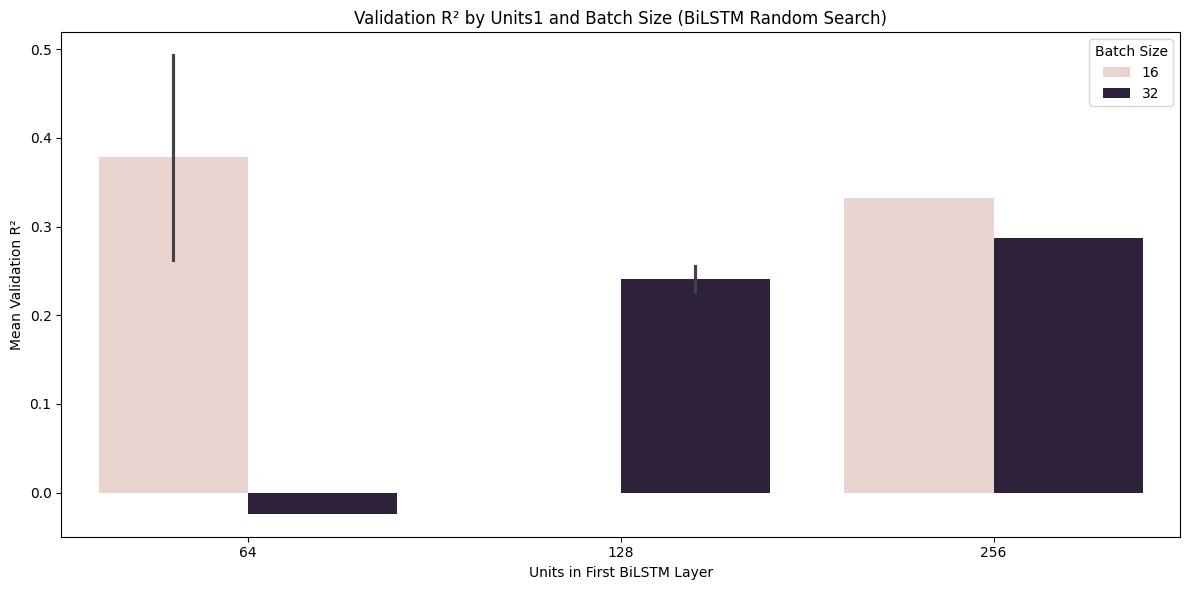

[Train] R²: 0.8679 | RMSE: 35060.54 | MAE: 27460.98
[Validation] R²: 0.9267 | RMSE: 28723.24 | MAE: 23055.56

Performance Summary After Fine-tuning:
   Dataset       R²         RMSE          MAE
     Train 0.867919 35060.544980 27460.975992
Validation 0.926666 28723.239511 23055.561932


In [13]:
# ------------------------
# Results DataFrame
# ------------------------
results_df = pd.DataFrame(random_result.cv_results_)

# Save all results
results_df.to_csv("bilstm_randomsearch_results.csv", index=False)

# Save the best performing model
print("\nSaving best model to disk...")
best_model = random_result.best_estimator_.model_  # Get the actual Keras model from KerasRegressor
best_model.save("best_bilstm_model.keras")

# Show top 5
print("\nTop 5 Results (sorted by mean_test_score):")
top5 = results_df.sort_values(by="mean_test_score", ascending=False).head(5)
print(top5[[
    "mean_test_score", "std_test_score", 
    "param_model__units1", "param_model__units2", 
    "param_model__dropout", "param_model__learning_rate", 
    "param_batch_size", "param_epochs"
]])

# ------------------------
# Best params
# ------------------------
print("\nBest Parameters:", random_result.best_params_)
print("Best Validation R² Score:", random_result.best_score_)

# ------------------------
# 📊 Visualization
# ------------------------
plt.figure(figsize=(12,6))
sns.barplot(
    data=results_df.sort_values(by="mean_test_score", ascending=False),
    x="param_model__units1", 
    y="mean_test_score",
    hue="param_batch_size"
)
plt.title("Validation R² by Units1 and Batch Size (BiLSTM Random Search)")
plt.xlabel("Units in First BiLSTM Layer")
plt.ylabel("Mean Validation R²")
plt.legend(title="Batch Size")
plt.tight_layout()
plt.show()


# 📌 Evaluate best BiLSTM model after fine-tuning
def evaluate_model(model, X, y, scaler, label):
    # 預測
    y_pred = model.predict(X, verbose=0)

    # 反轉縮放
    y_true_inv = scaler.inverse_transform(y.reshape(-1, 1)).reshape(y.shape)
    y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)

    # 計算指標
    r2 = r2_score(y_true_inv.flatten(), y_pred_inv.flatten())
    rmse = np.sqrt(mean_squared_error(y_true_inv.flatten(), y_pred_inv.flatten()))
    mae = mean_absolute_error(y_true_inv.flatten(), y_pred_inv.flatten())

    print(f"[{label}] R²: {r2:.4f} | RMSE: {rmse:.2f} | MAE: {mae:.2f}")
    return {"Dataset": label, "R²": r2, "RMSE": rmse, "MAE": mae}

# 📊 計算 Train / Validation
train_metrics = evaluate_model(best_model, X_train, y_train, scaler, "Train")
val_metrics   = evaluate_model(best_model, X_val, y_val, scaler, "Validation")

# 📊 整理成表格
metrics_df = pd.DataFrame([train_metrics, val_metrics])
print("\nPerformance Summary After Fine-tuning:")
print(metrics_df.to_string(index=False))

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# 📌 Evaluate best BiLSTM model after fine-tuning
def evaluate_model(model, X, y, scaler, label):
    # 預測
    y_pred = model.predict(X, verbose=0)

    # 反轉縮放
    y_true_inv = scaler.inverse_transform(y.reshape(-1, 1)).reshape(y.shape)
    y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)

    # 計算指標
    r2 = r2_score(y_true_inv.flatten(), y_pred_inv.flatten())
    rmse = np.sqrt(mean_squared_error(y_true_inv.flatten(), y_pred_inv.flatten()))
    mae = mean_absolute_error(y_true_inv.flatten(), y_pred_inv.flatten())

    print(f"[{label}] R²: {r2:.4f} | RMSE: {rmse:.2f} | MAE: {mae:.2f}")
    return {"Dataset": label, "R²": r2, "RMSE": rmse, "MAE": mae}

# 📊 計算 Train / Validation
train_metrics = evaluate_model(best_model, X_train, y_train, scaler, "Train")
val_metrics   = evaluate_model(best_model, X_val, y_val, scaler, "Validation")

# 📊 整理成表格
metrics_df = pd.DataFrame([train_metrics, val_metrics])
print("\nPerformance Summary After Fine-tuning:")
print(metrics_df.to_string(index=False))


[Train] R²: 0.8679 | RMSE: 35060.54 | MAE: 27460.98
[Validation] R²: 0.9267 | RMSE: 28723.24 | MAE: 23055.56

Performance Summary After Fine-tuning:
   Dataset       R²         RMSE          MAE
     Train 0.867919 35060.544980 27460.975992
Validation 0.926666 28723.239511 23055.561932


# 📌 Final Test Evaluation (Best BiLSRTM)


===== Final Test Evaluation (Best BiLSTM) =====
[Test] R²: 0.8481, RMSE: 41337.44, MAE: 33149.85, MAPE: 12.91%


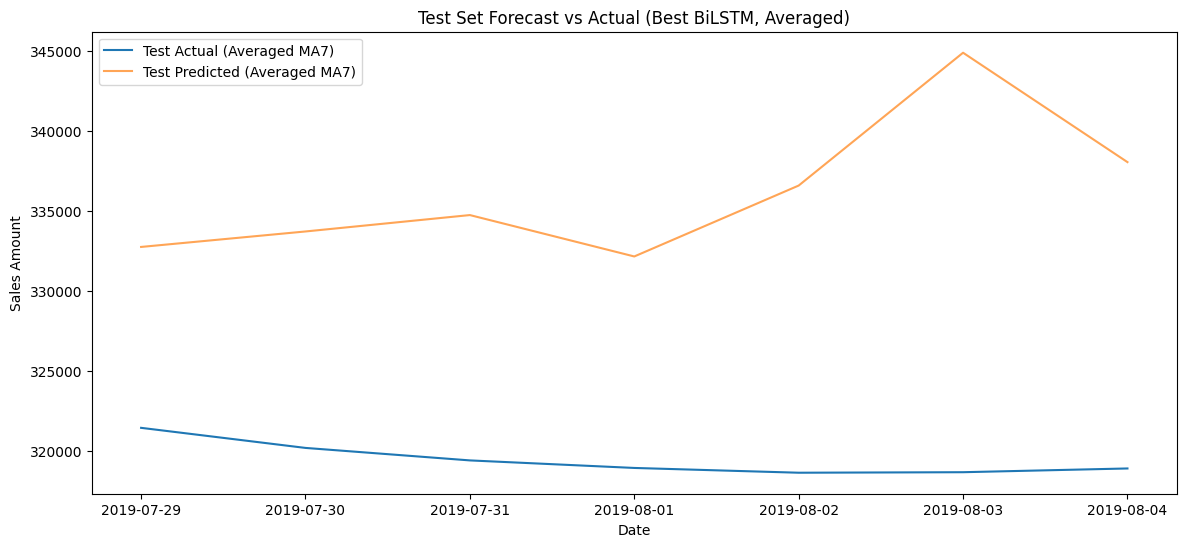

In [15]:
# Get the best model (already trained) found by RandomizedSearchCV
best_model = random_result.best_estimator_   

# ------------------------
# 📌 Evaluation Function (with MAPE)
# ------------------------
def evaluate_and_report(model, X, y, dataset_name):
    y_pred = model.predict(X, verbose=0)
    y_true_inv = scaler.inverse_transform(y.reshape(-1, 1)).reshape(y.shape)
    y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)

    r2 = r2_score(y_true_inv.flatten(), y_pred_inv.flatten())
    rmse = sqrt(mean_squared_error(y_true_inv.flatten(), y_pred_inv.flatten()))
    mae = mean_absolute_error(y_true_inv.flatten(), y_pred_inv.flatten())
    mape = np.mean(np.abs((y_true_inv.flatten() - y_pred_inv.flatten()) / y_true_inv.flatten())) * 100

    print(f"[{dataset_name}] R²: {r2:.4f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")
    return {"Dataset": dataset_name, "R²": r2, "RMSE": rmse, "MAE": mae, "MAPE (%)": mape}

# ------------------------
# 📌 Evaluate only on Test
# ------------------------
print("\n===== Final Test Evaluation (Best BiLSTM) =====")
test_results = evaluate_and_report(best_model, X_test, y_test, "Test")

# ------------------------
# 📊 Plot Test Forecast vs Actual (Best BiLSTM, Averaged)
# ------------------------
# Reshape predictions and true values back to (num_samples, OUTPUT_DAYS)
# Each row = one test sample, each column = one step in the forecast horizon
y_test_pred_seq = best_model.predict(X_test, verbose=0).reshape(-1, OUTPUT_DAYS)
y_test_true_seq = y_test.reshape(-1, OUTPUT_DAYS)

# Inverse transform back to original sales scale
# Step 1: flatten to 2D (n,1) so MinMaxScaler can process it
# Step 2: reshape back to (num_samples, OUTPUT_DAYS) after inverse scaling
y_test_pred_seq = scaler.inverse_transform(y_test_pred_seq.reshape(-1,1)).reshape(-1, OUTPUT_DAYS)
y_test_true_seq = scaler.inverse_transform(y_test_true_seq.reshape(-1,1)).reshape(-1, OUTPUT_DAYS)

# Align overlapping forecasts: average across all test samples for each forecast step
# This avoids multiple overlapping predictions for the same future day
avg_pred = y_test_pred_seq.mean(axis=0)
avg_true = y_test_true_seq.mean(axis=0)

# Build date index (length = OUTPUT_DAYS) for the averaged forecast horizon
test_index_avg = pd.date_range(
    start=daily_sales.index[split1+WINDOW_SIZE],  # test start date
    periods=OUTPUT_DAYS,                         # only OUTPUT_DAYS days (averaged horizon)
    freq="D"
)

# Plot averaged actual vs predicted values
plt.figure(figsize=(14,6))
plt.plot(test_index_avg, avg_true, label="Test Actual (Averaged MA7)")
plt.plot(test_index_avg, avg_pred, label="Test Predicted (Averaged MA7)", alpha=0.7)
plt.title("Test Set Forecast vs Actual (Best BiLSTM, Averaged)")
plt.xlabel("Date")
plt.ylabel("Sales Amount")
plt.legend()
plt.show()



Next 7 Days Forecast (Best BiLSTM):
        Date  Predicted Sales Amount (MA7)
0 2020-01-01                  307193.06250
1 2020-01-02                  349138.84375
2 2020-01-03                  407998.37500
3 2020-01-04                  451188.43750
4 2020-01-05                  463801.25000
5 2020-01-06                  468214.21875
6 2020-01-07                  459095.34375


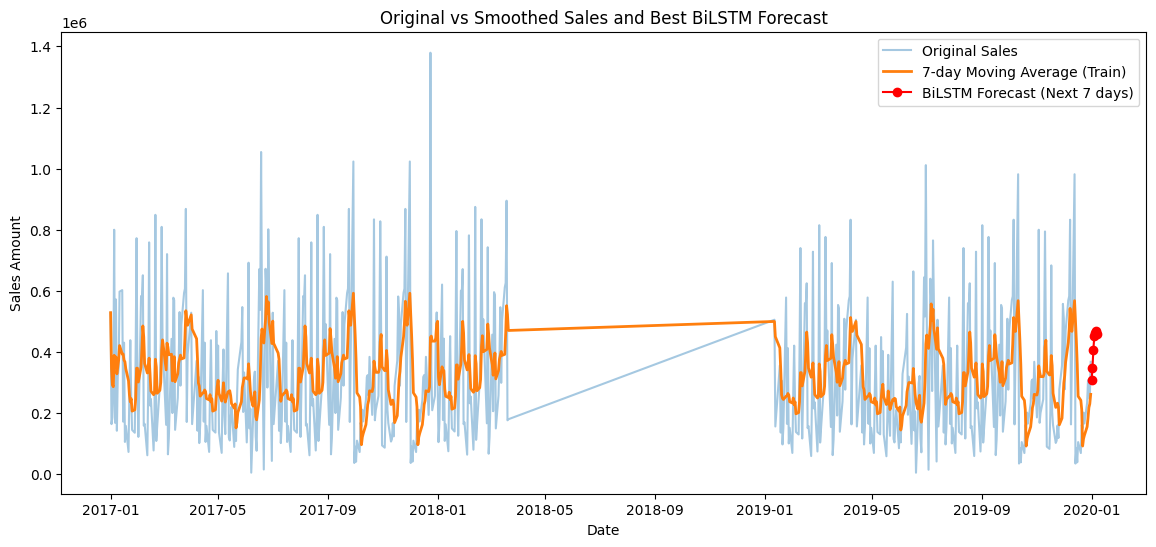

In [16]:
# ------------------------
# 📌 Forecast Next 7 Days
# ------------------------
last_input = scaler.transform(sales_series.values[-WINDOW_SIZE:].reshape(-1, 1)).reshape(1, WINDOW_SIZE, 1)
future_pred_scaled = best_model.predict(last_input, verbose=0)[0]
future_pred = scaler.inverse_transform(future_pred_scaled.reshape(-1, 1))

future_dates = pd.date_range(start=daily_sales.index[-1] + pd.Timedelta(days=1), periods=7)
forecast_df = pd.DataFrame({'Date': future_dates, 'Predicted Sales Amount (MA7)': future_pred.flatten()})
print("\nNext 7 Days Forecast (Best BiLSTM):")
print(forecast_df)

plt.figure(figsize=(14,6))
plt.plot(daily_sales.index, daily_sales['Sales Amount'], label="Original Sales", alpha=0.4)
plt.plot(daily_sales.index, daily_sales['Sales_MA7'], label="7-day Moving Average (Train)", linewidth=2)
plt.plot(forecast_df['Date'], forecast_df['Predicted Sales Amount (MA7)'],
         marker='o', label="BiLSTM Forecast (Next 7 days)", color="red")
plt.title("Original vs Smoothed Sales and Best BiLSTM Forecast")
plt.xlabel("Date")
plt.ylabel("Sales Amount")
plt.legend()
plt.show()